## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

"""
[train.csv]                                         [test.csv]
ID : 샘플별 고유 ID                                 ID : 샘플별 고유 ID
gender : 성별                                       gender : 성별
age : 연령                                          age : 연령
height : 키(cm)                                     height : 키(cm)
weight : 몸무게(kg)                                 weight : 몸무게(kg)
cholesterol : 콜레스테롤 수치                       cholesterol : 콜레스테롤 수치
systolic_blood_pressure : 수축기 혈압               systolic_blood_pressure : 수축기 혈압
diastolic_blood_pressure : 이완기 혈압              diastolic_blood_pressure : 이완기 혈압
glucose : 혈당 수치(mg/dL)                          glucose : 혈당 수치(mg/dL)
bone_density : 골밀도(g/cm²)                        bone_density : 골밀도(g/cm²)
activity : 생활시 운동 강도                         activity : 생활시 운동 강도
smoke_status : 흡연 상태                            smoke_status : 흡연 상태
medical_history : 만성질환                          medical_history : 만성질환
family_medical_history : 가족력                     family_medical_history : 가족력
sleep_pattern : 수면패턴                            sleep_pattern : 수면패턴
edu_level : 학력                                    edu_level : 학력
mean_working : 1주일당 평균 근로 시간               mean_working : 1주일당 평균 근로 시간
stress_score : (TARGET) 스트레스 점수                    
"""

display(train.shape)

(3000, 18)

## 2. 데이터 전처리

In [3]:
# 카테고리형 변수의 결측값을 최빈값으로 대체
# 최빈값 -> 가장 많이 관측된 값
categorical_na_cols = train.select_dtypes(include=['object', 'category']).columns.drop('ID')

for col in categorical_na_cols:
    # # 학습 데이터에서 최빈값 계산
    # most_frequent = train[col].mode()[0]
    # print(f"{col}: {most_frequent}")
    # # 학습 데이터와 테스트 데이터 모두 해당 칼럼의 최빈값으로 대체
    # train[col] = train[col].fillna(most_frequent)
    # test[col] = test[col].fillna(most_frequent)

    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

    print(f"{col}: {train[col].unique()}")

gender: ['F' 'M']
activity: ['moderate' 'light' 'intense']
smoke_status: ['ex-smoker' 'non-smoker' 'current-smoker']
medical_history: ['high blood pressure' 'None' 'diabetes' 'heart disease']
family_medical_history: ['diabetes' 'None' 'high blood pressure' 'heart disease']
sleep_pattern: ['sleep difficulty' 'normal' 'oversleeping']
edu_level: ['bachelors degree' 'graduate degree' 'high school diploma' 'None']


In [4]:
# mean_working에 대해 중앙값 대체
# median_value = train['mean_working'].median()

# mean_working 결측치 -> 0
train['mean_working'] = train['mean_working'].fillna(0)
test['mean_working'] = test['mean_working'].fillna(0)

display(train.columns)

Index(['ID', 'gender', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'smoke_status', 'medical_history',
       'family_medical_history', 'sleep_pattern', 'edu_level', 'mean_working',
       'stress_score'],
      dtype='object')

In [5]:
# One-Hot Encoding 적용 열 - gender, smoke_status, medical_history, family_medical_history
# 원핫 인코딩 => 카테고리끼리 순서 없을때 사용
# smoke_status는 좀 애매하긴 한듯
def one_hot_encoding(df):
    one_hot_encoding_cols = ['gender', 'smoke_status', 'medical_history', 'family_medical_history']
    encoding_df = pd.get_dummies(df, columns=one_hot_encoding_cols)
    return encoding_df

train = one_hot_encoding(train)
test = one_hot_encoding(test)

display(train.columns)
display(train.shape)

Index(['ID', 'age', 'height', 'weight', 'cholesterol',
       'systolic_blood_pressure', 'diastolic_blood_pressure', 'glucose',
       'bone_density', 'activity', 'sleep_pattern', 'edu_level',
       'mean_working', 'stress_score', 'gender_F', 'gender_M',
       'smoke_status_current-smoker', 'smoke_status_ex-smoker',
       'smoke_status_non-smoker', 'medical_history_None',
       'medical_history_diabetes', 'medical_history_heart disease',
       'medical_history_high blood pressure', 'family_medical_history_None',
       'family_medical_history_diabetes',
       'family_medical_history_heart disease',
       'family_medical_history_high blood pressure'],
      dtype='object')

(3000, 27)

In [6]:
# Label Encoding 적용 열 - activity, sleep_pattern, edu_level
# 라벨 인코딩 => 카테고리끼리 순서 있을때 사용
def label_encoding(df):
    label_encoding_cols = ['activity', 'sleep_pattern', 'edu_level']
    for feature in label_encoding_cols:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

train = label_encoding(train)
test = label_encoding(test)

In [7]:
train

,ID,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,...,smoke_status_ex-smoker,smoke_status_non-smoker,medical_history_None,medical_history_diabetes,medical_history_heart disease,medical_history_high blood pressure,family_medical_history_None,family_medical_history_diabetes,family_medical_history_heart disease,family_medical_history_high blood pressure
0,TRAIN_0000,72,161.49,58.47,279.84,165,100,143.35,0.87,2,...,True,False,False,False,False,True,False,True,False,False
1,TRAIN_0001,88,179.87,77.60,257.37,178,111,146.94,0.07,2,...,True,False,True,False,False,False,False,True,False,False
2,TRAIN_0002,47,182.47,89.93,226.66,134,95,142.61,1.18,1,...,True,False,True,False,False,False,True,False,False,False
3,TRAIN_0003,69,185.78,68.63,206.74,158,92,137.26,0.48,0,...,True,False,False,False,False,True,True,False,False,False
4,TRAIN_0004,81,164.63,71.53,255.92,171,116,129.37,0.34,2,...,True,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,TRAIN_2995,87,174.43,77.14,233.31,176,111,134.71,0.20,1,...,False,True,True,False,False,False,True,False,False,False
2996,TRAIN_2996,25,171.44,51.67,196.89,143,86,111.91,1.75,2,...,False,False,True,False,False,False,True,False,False,False
2997,TRAIN_2997,54,162.13,55.54,210.52,164,91,136.47,0.80,1,...,False,False,True,False,False,False,True,False,False,False
2998,TRAIN_2998,70,181.32,82.20,234.10,182,91,144.89,0.58,2,...,False,True,True,False,False,False,True,False,False,False


## 3. 피처 엔지니어링

In [8]:
# BMI => 몸무게[kg] / 키[cm]^2
# 혈압차(맥압) => 수축성 혈압 - 이완성 혈압
def add_features(df):
    df['BMI'] = df['weight'] / ((df['height']/100)**2)
    df['bp_diff'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
    return df

train = add_features(train)
test = add_features(test)

In [9]:
display(train['mean_working'].describe())

# working_group 피처 만들기
bins = [3, 8, 9, 16]  # 적절한 경계값 설정
labels = [0, 1, 2]     # 저, 중하, 중상, 고 근무

train['working_group'] = pd.cut(train['mean_working'], bins=bins, labels=labels, include_lowest=True)
test['working_group'] = pd.cut(test['mean_working'], bins=bins, labels=labels, include_lowest=True)

overwork_threshold = train['mean_working'].quantile(0.95)  # 상위 5% 기준값
train['is_overwork'] = (train['mean_working'] >= overwork_threshold).astype(int)
test['is_overwork'] = (test['mean_working'] >= overwork_threshold).astype(int)

display(train['working_group'].value_counts())
display(train['is_overwork'].value_counts())

count    3000.000000
mean        5.718333
std         4.346642
min         0.000000
25%         0.000000
50%         8.000000
75%         9.000000
max        16.000000
Name: mean_working, dtype: float64

working_group
0    888
2    543
1    537
Name: count, dtype: int64

is_overwork
0    2803
1     197
Name: count, dtype: int64

In [10]:
# mean_working & sleep_pattern 피처 엔지니어링

train['work_sleep_imbalance'] = train['mean_working'] / (train['sleep_pattern'] + 1)
test['work_sleep_imbalance'] = test['mean_working'] / (test['sleep_pattern'] + 1)

display(train[['work_sleep_imbalance', 'stress_score']])

for col in train.columns:
    if col not in ['ID', 'stress_score']:
        corr_val = train['stress_score'].corr(train[col])
        print(f"{col} ↔ stress_score 상관계수: {corr_val:.4f}")

,work_sleep_imbalance,stress_score
0,0.0,0.63
1,0.0,0.83
2,9.0,0.70
3,0.0,0.17
4,0.0,0.36
...,...,...
2995,0.0,0.02
2996,9.0,0.16
2997,9.0,0.16
2998,0.0,0.18


age ↔ stress_score 상관계수: 0.0187
height ↔ stress_score 상관계수: -0.0057
weight ↔ stress_score 상관계수: 0.0113
cholesterol ↔ stress_score 상관계수: 0.0213
systolic_blood_pressure ↔ stress_score 상관계수: 0.0156
diastolic_blood_pressure ↔ stress_score 상관계수: 0.0254
glucose ↔ stress_score 상관계수: -0.0061
bone_density ↔ stress_score 상관계수: -0.0226
activity ↔ stress_score 상관계수: 0.0070
sleep_pattern ↔ stress_score 상관계수: 0.0002
edu_level ↔ stress_score 상관계수: -0.0271
mean_working ↔ stress_score 상관계수: 0.0240
gender_F ↔ stress_score 상관계수: 0.0136
gender_M ↔ stress_score 상관계수: -0.0136
smoke_status_current-smoker ↔ stress_score 상관계수: 0.0261
smoke_status_ex-smoker ↔ stress_score 상관계수: -0.0320
smoke_status_non-smoker ↔ stress_score 상관계수: 0.0087
medical_history_None ↔ stress_score 상관계수: -0.0504
medical_history_diabetes ↔ stress_score 상관계수: 0.0245
medical_history_heart disease ↔ stress_score 상관계수: 0.0000
medical_history_high blood pressure ↔ stress_score 상관계수: 0.0373
family_medical_history_None ↔ stress_score 상관계수: -0.03

## 4. 교차검증

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

In [12]:
feature_cols = [c for c in train.columns if c not in ['ID','stress_score']] # ID와 stress_score를 제외한 나머지 칼럼 이름만 뽑아서 리스트
x_train = train[feature_cols]
y_train = train['stress_score']

y_binned = pd.qcut(y_train, q= 5, labels = False)
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) # Stratified K-Fold 설정: 5fold, 데이터 분포를 유지하며 섞기

for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y_binned),1): # 각 fold별 학습 & 검증
    X_tr, X_val = x_train.iloc[tr_idx], x_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    # tr_idx에는 4개의 fold 인덱스(학습셋) val_idx에는 1개의 fold 인덱스(검증셋)
    # 5번 반복 시 데이터의 모든 부분을 한번씩 검증셋 역할(5Fold 교차검증)

## 5. 모델링

In [13]:
x_train = train.drop(['ID', 'stress_score'], axis = 1)
x_val = train['stress_score']
y_train = train['stress_score']

test = test.drop('ID', axis = 1)

In [14]:
lgbm = LGBMRegressor(random_state = 42)
lgbm.fit(x_train, y_train)

pred = lgbm.predict(test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 30
[LightGBM] [Info] Start training from score 0.482130


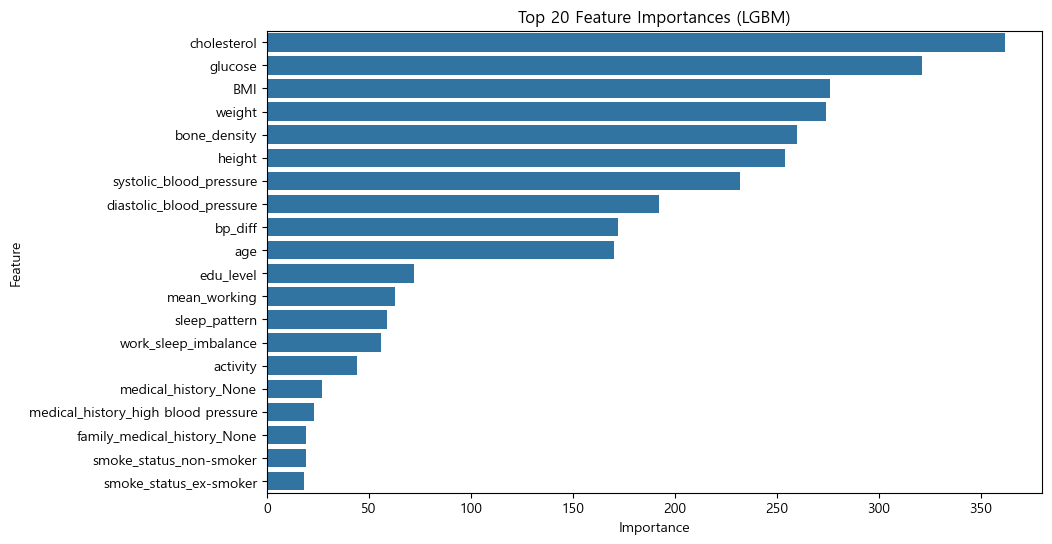

In [15]:
importances = lgbm.feature_importances_
feature_names = x_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (LGBM)')
plt.show()

In [16]:
submission = pd.read_csv('./sample_submission.csv')

In [17]:
submission['stress_score'] = pred
submission.head()

,ID,stress_score
0,TEST_0000,0.476419
1,TEST_0001,0.627898
2,TEST_0002,0.259774
3,TEST_0003,0.467328
4,TEST_0004,0.533462


In [18]:
submission.to_csv('submit.csv', index=False)

In [19]:
# train에서 나눠서 데이콘에서 측정하는 MAE와 다를수있음
# 성능이 올라갔는지 그대로인지 내려갔는지 경향만 파악할 수 있음
# 확인용으로만 쓸것

import datetime

# MAE 로그파일 세팅
def loging(MAE):
    with open('./mae_log', mode='a', encoding='utf-8') as f:
        current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        f.write(f"시간: {current_time} / MAE: {MAE}\n")

# MAE 체크용
train_set, val_set = train_test_split(train, test_size=0.2, random_state=42)

X_train = train_set.drop(['ID', 'stress_score'], axis=1)
y_train = train_set['stress_score']

X_val = val_set.drop(['ID', 'stress_score'], axis=1) 
y_val = val_set['stress_score']

lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)

val_pred = lgbm.predict(X_val)

MAE = mean_absolute_error(y_val, val_pred)

print(f"모델의 검증 MAE 점수: {MAE}")
loging(MAE)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 30
[LightGBM] [Info] Start training from score 0.481912
모델의 검증 MAE 점수: 0.20224606918306098
